# Classification
Classification (predicting classes), regression (predicting values)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.datasets import fetch_openml
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

In [2]:
IMAGE_PATH = Path() / 'images' / 'c2_clf'
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = IMAGE_PATH / f'{fig_id}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
## load dataset
mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
## DESCR: a description of data 
## data: the input data (2D array)
## target: the labels (1D array)
# print(mnist.DESCR)

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist.data, mnist.target

In [7]:
X[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
y[:5]

array(['5', '0', '4', '1', '9'], dtype=object)

In [9]:
X.shape, y.shape

((70000, 784), (70000,))

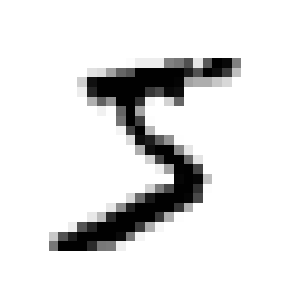

In [10]:
## display the data under picture
def plot_digit(image_data):
    image = image_data.reshape(28, 28) # 28*28=784 the size of pic
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
some_digit = X[0]
plt.figure(figsize=(4, 3))
plot_digit(some_digit)
save_fig('some_digit_plot')
plt.show()

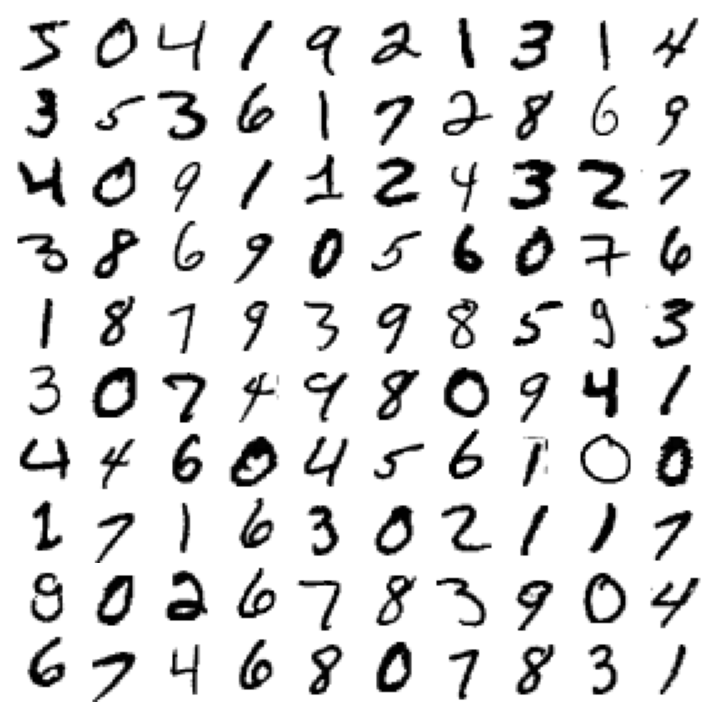

In [11]:
plt.figure(figsize=(9,9))
for idx, image in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# True for all 5s, False for other digits
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [14]:
X_train.shape, X_test.shape

((63000, 784), (7000, 784))

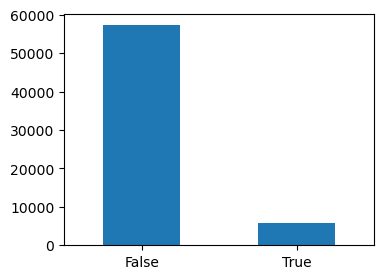

In [15]:
pd.Series(y_train_5).value_counts().plot(kind='bar', rot=0, figsize=(4, 3))
plt.show()

In [16]:
## SGDC can deal with very large dataset efficiently
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measure
### Measuring Accuracy, Percision, Recall, F1, and Confusion Matrix using Cross-Validation

In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96252381, 0.96042857, 0.96014286])

In [19]:
## implement own cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # split dataset into 3 parts

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    # make a clone of the clf
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_fold = X_train[test_idx]
    y_test_fold = y_train_5[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9625238095238096
0.9604285714285714
0.9601428571428572


## 1. Confusion Matrix
- Count the number of times instances of class A are classified as class B, for all A/B pairs.

Using cross_val_predict() to make a predictions on training dataset and its validation dataset.

The row contains actual class, the column represents the predicted class:
- First row, first column is the non-5 instances (negative class), and number of correctly counting as non-5 classes (TN). Second column is wrongly classified as class 5 (FP, also called type I errors).
- Second row, first column is the number of 5s wrongly classified (FN, called type II errors), and number of 5s are correctly classified (TP).

The perfect classify would only have TP and TN.

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
cm = confusion_matrix(y_train_5, y_train_pred)#, normalize='true')
cm

array([[56231,  1065],
       [ 1390,  4314]])

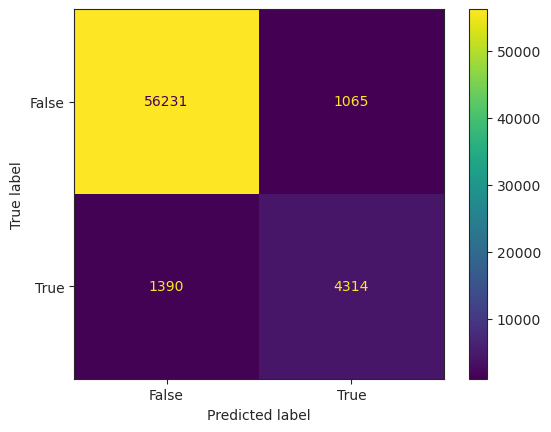

In [22]:
sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_clf.classes_).plot()
plt.show()

### 1.1. Precision and Recall
#### Precision
The Positive predictions, $Precision = \frac{TP}{FP + TP}$
#### Recall
The Sensitivity or the True Positive Rate (TPR), this is the ratio of positive instances that are correctly detected by the classifier: $Recall = \frac{TP}{FN + TP}$ 
#### F1 score
The Harmonic mean of Precision and Recall, it is useful when we go to compare two classifiers:  $F_1 = 2 x \frac{precision + recall}{precision x recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

## precision
precision_score(y_train_5, y_train_pred)

0.8020078081427775

In [24]:
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8020078081427775

In [25]:
## recall
recall_score(y_train_5, y_train_pred)

0.7563113604488079

In [26]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.7563113604488079

- The 5-detector classifier is only 75.6% correct prediction on the 5s.

In [27]:
f1_score(y_train_5, y_train_pred)

0.7784895786339439

## 2. Precision/Recall Tradeoff
The decision threshold in the classifier help to increase/descrease the precision/recall when we raise up or reduce down the threshold.

In sklearn do not let to set the threshold directly, but let's access to the decision score that uses to make prediction, with the ```decision_function()``` instead of call predict(), then use any customized threshold to make predictions based on this score.

In [28]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2602.05559655])

In [29]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  6737.45754139,  -8441.51643144, -21998.51241851, ...,
       -11163.09380556,  -8347.34084909, -14233.48283647])

In [31]:
from sklearn.metrics import precision_recall_curve

## compute precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

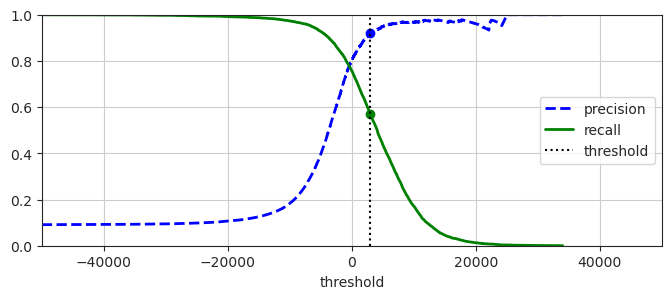

In [32]:
## plot precision, recall as function of the threshold value
plt.figure(figsize=(8, 3))
plt.plot(thresholds, precisions[:-1], 'b--', label="precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='recall', linewidth=2)

## setup the manual threshold
threshold = 3000
idx = (thresholds >= threshold).argmax() # first index >= threshold
plt.plot(thresholds[idx], precisions[idx], 'bo') 
plt.plot(thresholds[idx], recalls[idx], 'go')
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')
plt.axis([-50000, 50000, 0, 1])
plt.xlabel('threshold')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

- High Recall means the classifier returns most of relevant instances. Recall measures the quantity
- High Precision means the classifier returns more relevant instances than irrelevent ones. Precision measures the quality

At this threshold, the Precision is more than 90% and Recall is around 60%.
- 90% the classifier correctly predict number of 5s. and 10% of non-5 numbers that they are classified as 5s. 
- 60% the classifier correctly predict number of 5s, and 40% of 5s that are wrongly classified as other numbers. 

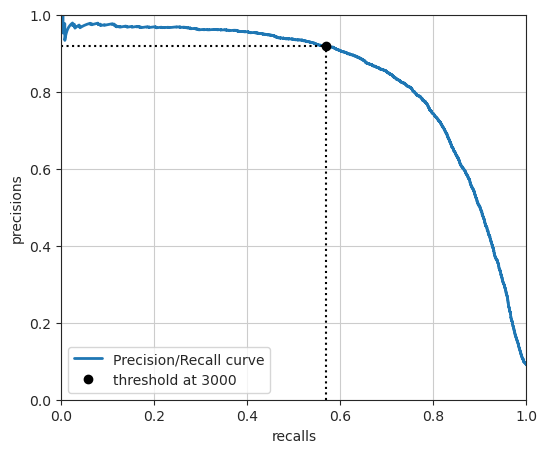

In [33]:
## plot tradeoff curve
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')
plt.plot(recalls[idx], precisions[idx], 'ko', label='threshold at 3000')
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.xlabel("recalls")
plt.ylabel('precisions')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend()
plt.show()

In [34]:
## identify the threshold at precision 90%
idx_prec_90 = (precisions >= 0.90).argmax() # first index of the maximum values
threshold_for_90 = thresholds[idx_prec_90]
threshold_for_90

2315.516087576324

In [35]:
y_train_at_90_precision = (y_scores >= threshold_for_90)
y_train_at_90_precision

array([ True, False, False, ..., False, False, False])

In [36]:
precision_score(y_train_5, y_train_at_90_precision)

0.9000770613922425

In [37]:
recall_score(y_train_5, y_train_at_90_precision)

0.6143057503506312

In [38]:
np.array(np.array([2, 3, 4, 1, 4, 6]) >= 4)

array([False, False,  True, False,  True,  True])

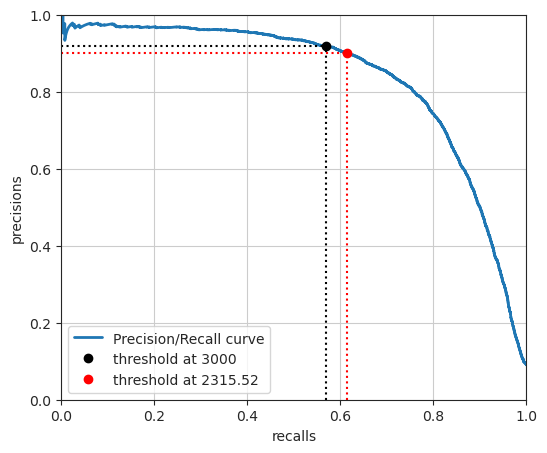

In [39]:
## plot tradeoff curve
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')
plt.plot(recalls[idx], precisions[idx], 'ko', label='threshold at 3000')
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot(recalls[idx_prec_90], precisions[idx_prec_90], 'ro', label=f'threshold at {np.round(threshold_for_90, 2)}') 
plt.plot([0., recalls[idx_prec_90]], [precisions[idx_prec_90], precisions[idx_prec_90]], 'r:')
plt.plot([recalls[idx_prec_90], recalls[idx_prec_90]], [0., precisions[idx_prec_90]], 'r:')
plt.xlabel("recalls")
plt.ylabel('precisions')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend()
plt.show()

## ROC curve
The Receiver Operating Characteristic (ROC) curve is another common tool used with binary classifiers. The ROC curve plots the True Positive Rate (recall) against the False Positive Rate (FPR). the FPR (called fall-out) is the ratio of negative instances that are incorrectly classified as positive. Equally to ```1 - TNR (True Negative Rate)```. The TNR (called specificity) is the ratio of negative instances that are correctly classified as the negative. Hence, the ROC curve plots ```sensitivity (recall) vs. 1 - specificity```.

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

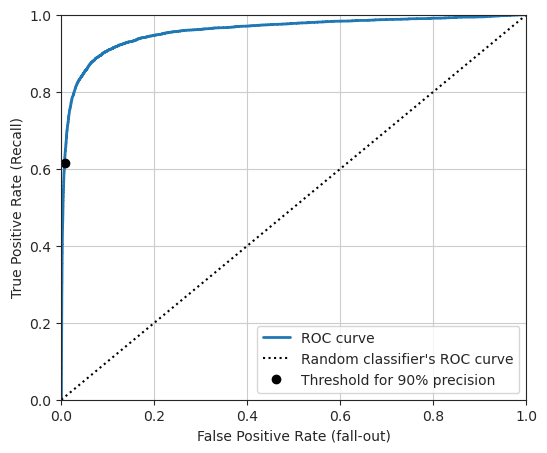

In [41]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 90% precision')
plt.xlabel('False Positive Rate (fall-out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend()
plt.show()

So, the tradeoff: the heigher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of purely random classifier, a good classifier stays as far away from that line as possible (toward the top-left corner).

Another way to compare classifiers is to measure the ```area under curve (AUC)```. A perfect classifier has ROC AUC roughtly equal 1, and the worse classifier equals to 0.5.

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9583434042278614

In [43]:
## Lets try with another classifier to compare PR and F1 score
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

## the RandomForestClassifier doesn't have function to return the score for each instance. 
## But it has the predict_proba() to return the probability for each instance
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, method='predict_proba', cv=3)

In [48]:
y_proba_forest[:3]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04]])

In [49]:
y_proba_forest[:3].max(axis=1)

array([0.89, 0.99, 0.96])

- This estimate probabilities, it predict the first image is positive with 89% proba, and the second is negative with 99% proba.

In [51]:
# Among the images that the model classified as positve with probability between 50% and 60%.
idx_50_to_60 = (y_proba_forest[:, 1] >= 0.5) & (y_proba_forest[:, 1] <= 0.6)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

92.6%


In [52]:
# Compute precision, recall, and threshold of the positive class
y_scores_forest = y_proba_forest[:, 1]  # get the positive column
forest_precisions, forest_recalls, forest_thresholds = precision_recall_curve(y_train_5, y_scores_forest)

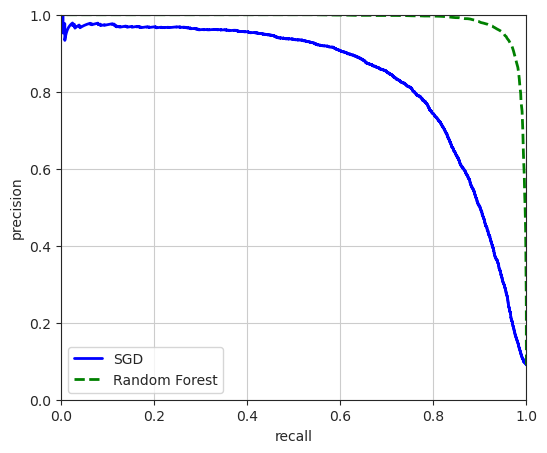

In [54]:
# plot the tradeoff precisions and recalls 
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, 'b-', linewidth=2, label='SGD')
plt.plot(forest_recalls, forest_precisions, 'g--', linewidth=2, label='Random Forest')
plt.xlabel('recall')
plt.ylabel('precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend()
plt.show()

We could use ```cross_val_predict(forest_clf, X_train, y_train_5, cv=3)``` to compute ```y_train_pred_forest```, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [55]:
y_train_pred_forest = y_proba_forest[:, 1] >= .50
y_train_pred_forest[:5]

array([ True, False, False, False, False])

In [56]:
f1_score(y_train_5, y_train_pred_forest)

0.9280193686562995

In [57]:
roc_auc_score(y_train_5, y_train_pred_forest)

0.936344953868653

In [58]:
precision_score(y_train_5, y_train_pred_forest)

0.9896722939424032

In [59]:
recall_score(y_train_5, y_train_pred_forest)

0.8735974754558204